In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm

### What does scipy.stats.norm.cdf() do?
This function returns the cumulative area to the left of a given point under a normal distribution with user-defined center and scale.
We use this function when computing p-value for MR estimate. 

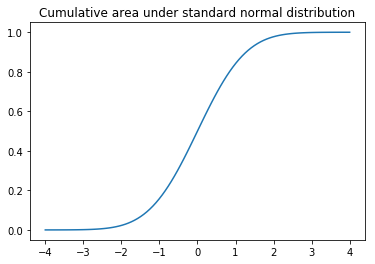

Cumulative area at -1.96: 	0.024997895148220435
Cumulative area at 1.96: 	0.9750021048517795


In [3]:
x = np.linspace(-4, 4, num=100)
y = norm.cdf(x, loc=0, scale=1)
plt.plot(x,y)
plt.title('Cumulative area under standard normal distribution')
plt.show()

for i in [-1.96, 1.96]:
    print('Cumulative area at %s: \t%s'%(i,norm.cdf(i)))

### Computing MR estimates, standard error, confidence interval and p-value for a given SNP.  
- beta_x = effect of SNP on exposure
- beta_y = effect of SNP on outcome
- se_y = standard error beta_y

In [2]:
class Instrumental_SNP:
  def __init__(self, rsid, beta_x, beta_y, se_y):
    self.rsid = rsid
    self.MR_beta = beta_y/beta_x
    self.MR_se = se_y/abs(beta_x)
    self.MR_95CIL = self.MR_beta - 1.96 * self.MR_se
    self.MR_95CIU = self.MR_beta + 1.96 * self.MR_se
    self.MR_p = 2*(1-norm.cdf(abs(self.MR_beta)/self.MR_se))

### Inverse Variance Weighting
Given a sequence of observations $y_i$, with variances $\sigma^2_i$, the inverse variance weighted average (IVW) is:
$$
\hat{y} = \frac{\sum_i \frac{y_i}{\sigma^2_i}}{\sum_i \frac{1}{\sigma^2_i}}
$$

If the variances are all equal, then the IVW average becomes the simple average.

### Reading through aligned files, compute MR estimates, make forest plots.
- "xx.aligned.tsv" files are of format: rsid \t beta_x \t beta_y \t se_y (without spaces)

- How SNPs were aligned (manually in excel):
    - For each SNP:
        - If necessary, swap reference allele for EXPOSURE-beta such that EXPOSURE-beta is decreasing.
        - If necessary, swap reference allele for OUTCOME-beta such that it matches reference allele for EXPOSURE-beta.
            - If reference allele for OUTCOME-beta was swapped, flip sign of OUTCOME-beta.

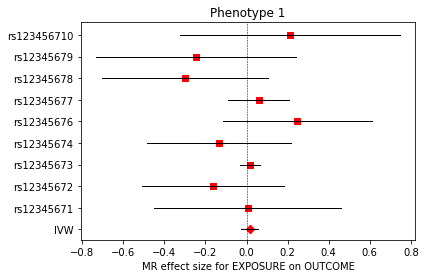

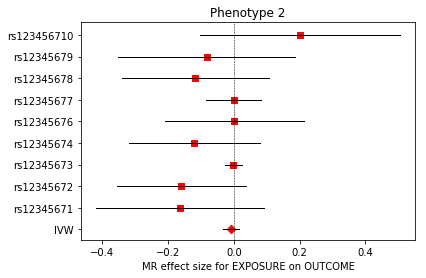

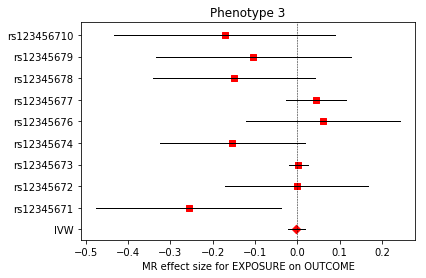

In [20]:
for filepath, phenotype in zip(['phenotype1.aligned.tsv',
                             'phenotype2.aligned.tsv',
                             'phenotype3.aligned.tsv'], 
                            ['Phenotype 1', 
                             'Phenotype 2', 
                             'Phenotype 3']):
    
    # Make list of SNP objects from file
    instrument_list = []
    invalid_snps = ['rs12345675']
    with open(filepath, 'r') as infile:
        next(infile)
        for line in infile:
            data = line.rstrip().split('\t')
            rsid, beta_x, beta_y, se_y = [data[0]] + [float(i) for i in data[1:]]
            if rsid not in invalid_snps:
                instrument_list.append(Instrumental_SNP(rsid, beta_x, beta_y, se_y))
    
    # Compute IVW estimate    
    MR_betas = [snp.MR_beta for snp in instrument_list]
    ivw_weights = [snp.MR_se**(-2) for snp in instrument_list]
    ivw_beta = np.dot(MR_betas, ivw_weights) / np.sum(ivw_weights)
    ivw_se = np.sum(ivw_weights)**(-1/2)
    ivw_95CIL = ivw_beta - 1.96 * ivw_se
    ivw_95CIU = ivw_beta + 1.96 * ivw_se

    # Plot IVW estimate
    plt.scatter(ivw_beta, 0, marker = 'D', color='r')
    plt.plot((ivw_95CIL, ivw_95CIU), (0, 0), 'k-', linewidth=1)
    
    # Plot individual MR estimates
    for i, snp in enumerate(instrument_list, start=1):
        plt.scatter(snp.MR_beta, i, marker='s', color='r')
        plt.plot((snp.MR_95CIL, snp.MR_95CIU), (i, i), 'k-', linewidth=1)
        
    # Graph stuff
    plt.axvline(0, ls ='--', color='k',linewidth=0.5)
    plt.yticks([y for y in range(len(instrument_list)+1)], 
               ['IVW'] + [snp.rsid for snp in instrument_list])
    plt.xlabel('MR effect size for EXPOSURE on OUTCOME')
    plt.title(phenotype)
    plt.show()